## Continued Exploration of High Scoring Affairs
In soccer analytics there are many results considered.  Because coaching is also interested in patterns in the game, the hidden truths in the data, and a question was posed regarding high scoring games.  Is there a pattern which these games fall into, where defense is thrown out the window and goals come in high numbers.  Soccer/Football is for all intents and purposes a low scoring game. The introduction of the 3 point win was a huge shift in teams pursuing wins and not draws.  Even so, two to three goals is a pretty common outcome for a match.

What about the exceptions?  Not the one sided exceptions.  The track meets where the last team with the ball might be the winner.  The games where goals come fast and furious, but no team has a significant advantage.  Score lines like 4-3 or 5-5 come to mind.  Games with at least six goals which are well distributed.  Is there anything to learn from these *High Scoring Affairs*?

The first notebook analysis identified the data aggregation views.  This highlighted that more shots were taken, and they were taken closer to the goal.  Analysis of passing and recieve patterns for both HSA and non HSA games showed basically the same distibution of patterns, as did the turnover locations follow state likelywise.  Here, the goal will be to see how shots develop in live play through passing patterns.

---
### Imports and Data

In [1]:
import mplsoccer as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import pandas as pd
import numpy as np

from statsbombpy import sb
# suppress due to free data warning
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)

### Competitions

In [2]:
# Break down on total seasons by competition name
(sb.competitions(creds={'user': None, 'passwd': None})
 .competition_name.value_counts()
 .rename('Seasons')
)

competition_name
Champions League           18
La Liga                    18
FIFA World Cup              8
Ligue 1                     3
Copa del Rey                3
FA Women's Super League     3
Liga Profesional            2
Serie A                     2
Premier League              2
Women's World Cup           2
African Cup of Nations      1
Major League Soccer         1
North American League       1
NWSL                        1
Indian Super league         1
FIFA U20 World Cup          1
UEFA Euro                   1
UEFA Europa League          1
UEFA Women's Euro           1
1. Bundesliga               1
Name: Seasons, dtype: int64

### Match Example

In [3]:
sb.matches(11,1).iloc[0] # characteristic record

match_id                                       9880
match_date                               2018-04-14
kick_off                               16:15:00.000
competition                         Spain - La Liga
season                                    2017/2018
home_team                                 Barcelona
away_team                                  Valencia
home_score                                        2
away_score                                        1
match_status                              available
match_status_360                          scheduled
last_updated             2023-02-08T17:23:53.901920
last_updated_360            2021-06-13T16:17:31.694
match_week                                       32
competition_stage                    Regular Season
stadium                            Spotify Camp Nou
referee                     Carlos del Cerro Grande
home_managers              Ernesto Valverde Tejedor
away_managers                Marcelino García Toral
data_version

### HSA Record Inspection
The match_id along with the home and away score can be inspected from the data which is available.  A column will need to be added for the total match goals and total differential, and finally a binary for HSA classification.  This can then be used to add match_ids to a dataframe/list for extraction of event data.

In [4]:
def hsa_add(df, goals=4, diff=3):
    '''Adds columns for total goals, total goal differential and HSA classifier.
    Returns dataframe where games are considered High Scoring Affairs or HSAs.
    df = dataframe from statsbomb
    goals = number in total to exceed in game
    diff = difference between score threshold'''
    df_update = (df
                 .assign(total_goals = lambda df: df.home_score + df.away_score,
                         goal_diff = lambda df: abs(df.home_score - df.away_score),
                         HSA = lambda df: np.where(df.total_goals>goals,np.where(df.goal_diff<diff,1,0),0))
                 ).query('HSA==1')
    return df_update

In [5]:
def non_hsa_add(df, goals=4, diff=3):
    '''Adds columns for total goals, total goal differential and HSA classifier.
    Returns dataframe where games are considered High Scoring Affairs or HSAs.
    df = dataframe from statsbomb
    goals = number in total to exceed in game
    diff = difference between score threshold'''
    df_update = (df
                 .assign(total_goals = lambda df: df.home_score + df.away_score,
                         goal_diff = lambda df: abs(df.home_score - df.away_score),
                         HSA = lambda df: np.where(df.total_goals>goals,np.where(df.goal_diff<diff,1,0),0))
                 ).query('HSA==0')
    return df_update

### Extract Competitions and Seasons
Extract all competitions and seasons, then extract and append all of the HSA games into a single database so the match_ids can be pull and the event data can be evaluated. Here, both the HSA and Non_HSA classified matches can be extracted.  

In [6]:
def extract_comps(df):
    '''Extract a list of tuples for compeition and season ids.'''
    L = []
    for ind, row in (df.iterrows()):
        L.append((row.competition_id, row.season_id))
    return L

In [7]:
try:
    hsa_df = pd.read_csv('./data/hsa_df.csv')
    print('Read CSV from memory')
except:  # noqa: E722
    hsa_df = pd.DataFrame()
    for i in extract_comps(sb.competitions()):
        hsa_df= pd.concat([hsa_df,hsa_add(sb.matches(i[0],i[1]),5,3)])
    print('Used Statsbomb API')
    hsa_df.to_csv('./data/hsa_df.csv')
    

Read CSV from memory


In [8]:
try:
    non_hsa_df = pd.read_csv('./data/non_hsa_df.csv')
    print('Read CSV from memory')
except:  # noqa: E722
    non_hsa_df = pd.DataFrame()
    for i in extract_comps(sb.competitions()):
        non_hsa_df= pd.concat([non_hsa_df,non_hsa_add(sb.matches(i[0],i[1]),5,3)])
    print('Used Statsbomb API')
    non_hsa_df.to_csv('./data/non_hsa_df.csv')
    

Read CSV from memory


In [9]:
hsa_matches = hsa_df.reset_index().match_id.values

In [10]:
non_hsa_matches = non_hsa_df.reset_index().match_id.values

In [11]:
print(len(hsa_matches))
print(len(non_hsa_matches))

110
3206


### Total Available Matches
In total, there are 110 matches across the entire dataset of competitions in the Statsbomb free datasets.  Without having inspected the specifics, that feels about right.  It wouldn't do to have thousands of matches in this category.  More often, soccer is a low scoring game.  Achieving more than 5 goals with a difference of less than 3 is an uncommon result.

### Extracting Events
All events are extracted and aggregated across all 110 HSA and the 110 non HSA matches in this analysis. 

In [12]:
# defining universal event extractor function
def full_event_extract(match_ids):
    '''Returns all events using the statsbomb library and the match list previously defined.
    matchid = number or array of numbers containing matchid
    '''
    event_df = pd.DataFrame()
    for i in match_ids:
        event_df = pd.concat([sb.events(i),event_df])
    return event_df

In [13]:
try:
    hsa_events_df = pd.read_csv('./data/hsa_events_df.csv')
    print('read CSV')
except:  # noqa: E722
    hsa_events_df = (full_event_extract(hsa_matches)
                    .dropna(axis=1, how='all')
                    .assign(time = lambda df: pd.to_timedelta(df.timestamp))
                    )
    print('Used statsbomb API')
    hsa_events_df.to_csv('./data/hsa_events_df.csv')

read CSV


In [14]:
try:
    non_hsa_events_df = pd.read_csv('./data/non_hsa_events_df.csv')
    print('read CSV')
except:  # noqa: E722
    np.random.seed(42)
    non_hsa_events_df = (full_event_extract(np.random.choice(non_hsa_matches,size=110))
                    .dropna(axis=1, how='all')
                    .assign(time = lambda df: pd.to_timedelta(df.timestamp))
                    )
    print('Used statsbomb API')
    non_hsa_events_df.to_csv('./data/non_hsa_events_df.csv')

read CSV


### Xt and Possession Chains
Moving into more refined analysis, the possession chains which lead to goals will be evaluated to determine the difference between HSA games and Non HSA games.  Do the HSA games demonstrate longer chains? Is length based on the number of passes or the amount of time in possession before a shot occurs.  The focus for this analysis will be on chains which result in a shot or goal, since that is the primary focus of this analysis.

Using the turtorial from MPL soccer, the expected threat matrix will be recreated and used to evaluate possessions in both the HSA and Non HSA games.  The Statsbomb data comes with possession chains highlighted, so the designation of chains has been taken care of as shown below.  

In [16]:
(hsa_events_df
 .query("match_id==68338 and possession.isin([2,3,4])")
 .loc[:,['index','possession','possession_team','type','location','shot_outcome','match_id','minute','period','timestamp','id','related_events']]
 .sort_values(by='index')
).head(3)

,index,possession,possession_team,type,location,shot_outcome,match_id,minute,period,timestamp,id,related_events
6,5,2,Argentina Women's,Pass,"[61.0, 40.1]",NaN,68338,0,1,00:00:00.240,541a0851-b8d8-40c1-94fa-7a691cfd5c71,['7d973b5e-9724-4474-9311-a599ea4cf5c6']
793,6,2,Argentina Women's,Ball Receipt*,"[41.4, 36.0]",NaN,68338,0,1,00:00:01.574,7d973b5e-9724-4474-9311-a599ea4cf5c6,['541a0851-b8d8-40c1-94fa-7a691cfd5c71']
1499,7,2,Argentina Women's,Carry,"[41.4, 36.0]",NaN,68338,0,1,00:00:01.574,62ad2742-4b2d-4c1c-9761-66eb9f2c4c7a,"['25d41cf4-96d0-4781-9130-a43a376fd553', '7d97..."


---
## Xt Model
Taken from MPLsoccer tutorial and reapplied to the games of interest for analysis.


### The Grid
Our first decision, is how to grid the soccer field. Here we copy the MPLsoccer setup and have 16 cells in the x-direction and 12 cells in the y-direction.

In [17]:
# Set up the grid
bins = (16,12)

Create a dataframe of the events using the column equivalents shown below: 
```cols = ['match_id', 'id', 'type_name', 'sub_type_name', 'player_name',
        'x', 'y', 'end_x', 'end_y', 'outcome_name', 'shot_statsbomb_xg']```

In [55]:
hsa_xT_event_df = (hsa_events_df
 .loc[:,['match_id','id','type','player','location','pass_end_location','shot_outcome','shot_statsbomb_xg']]
 .query('type.isin(["Carry","Shot","Pass"])')
 .assign(goal = lambda df: np.where(df.shot_outcome=="Goal",1,0),
         shoot = lambda df: np.where(df.type == "Shot",1,0),
         move = lambda df: np.where(df.type != "Shot",1,0),
         x = lambda df: df.location.apply(lambda x:eval(x)[0]),
         y = lambda df: df.location.apply(lambda y:eval(y)[1]))
)

### Bin the data
Calculate the probability of a shot, successful move (pass or carry), and goal (given a shot). Averaging the boolean columns (True = 1) and (False = 0) to give us the probability between zero and one.

In [56]:
pitch = mpl.Pitch(line_zorder=2)

In [58]:
event=hsa_xT_event_df
shot_probability = pitch.bin_statistic(event['x'], event['y'], values=event['shoot'],
                                       statistic='mean', bins=bins)
move_probability = pitch.bin_statistic(event['x'], event['y'], values=event['move'],
                                       statistic='mean', bins=bins)
goal_probability = pitch.bin_statistic(event.loc[lambda df: df.shoot==1, 'x'],
                                       event.loc[lambda df: df.shoot==1, 'y'],
                                       event.loc[lambda df: df.shoot==1, 'goal'],
                                       statistic='mean', bins=bins)

### Plot shot and move probability
Move probabilities are the mirror of the shot probability. The shot_probability + goal_probability adds up to one for each grid cell, as we assume only these two event types occur when in possession.

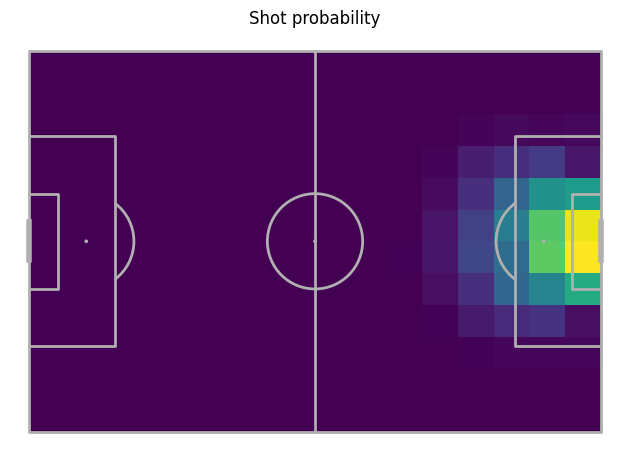

In [64]:
fig, ax = pitch.draw()
shot_heatmap = pitch.heatmap(shot_probability, ax=ax)
ax.set_title('Shot probability');

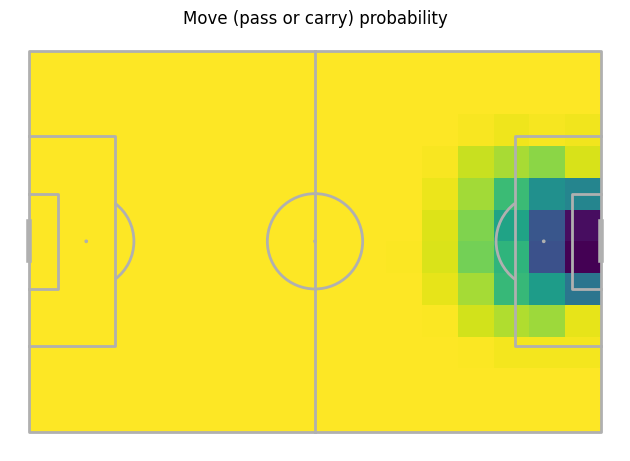

In [65]:
fig, ax = pitch.draw()
move_heatmap = pitch.heatmap(move_probability, ax=ax)
ax.set_title('Move (pass or carry) probability');

### Plot goal probability
This is the likelihood of scoring from a shot, versus the likelihood of shooting.  Earlier, the views were not based on scoring chance, but the attractiveness of a possition for shooting.  

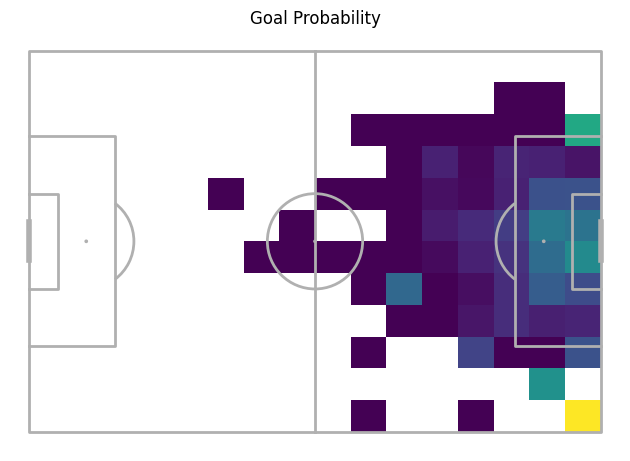

In [68]:
fig, ax = pitch.draw()
goal_heatmap = pitch.heatmap(goal_probability, ax=ax)
ax.set_title('Goal Probability');